In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler  #The StandardScaler is commonly employed to standardize or normalize features in a dataset by transforming them to have a mean of 0 and a standard deviation of 1. This ensures that all features contribute equally to the model.

# Load data
df = pd.read_csv("data_utf8.csv")

# Convert 'date' column to datetime and extract month, day, and year
df["month"] = pd.to_datetime(df["date"]).dt.strftime('%b')  # E.g., Jan, Feb
df["day"] = pd.to_datetime(df["date"]).dt.day               # Day as a number (1-31)
df["year"] = pd.to_datetime(df["date"]).dt.year             # Year as a four-digit number


# Save the updated DataFrame back to the same file
df.to_csv("new_data.csv", index=False)

# imputation

#first remove unnecessary columns
df = df.drop(['stn_code', 'sampling_date', 'date', 'location_monitoring_station', 'pm2_5', 'agency'], axis=1)
# axis=1: Indicates that you're dropping columns (not rows)
print(df.head())
print(df.isnull().sum())


# Remove rows where all three columns 'month', 'day', and 'year' are missing
df = df.dropna(subset=['month', 'day', 'year'], how='all')
print(df.isnull().sum())

# Impute 'rspm' based on the mean of 'rspm' for each month
month_means = df.groupby('month')['rspm'].transform('mean')
df['rspm'] = df['rspm'].fillna(month_means)

month_means1 = df.groupby('month')['spm'].transform('mean')
df['spm'] = df['spm'].fillna(month_means1)

month_means2 = df.groupby('month')['so2'].transform('mean')
df['so2'] = df['so2'].fillna(month_means2)

month_means3 = df.groupby('month')['no2'].transform('mean')
df['no2'] = df['no2'].fillna(month_means3)

# for locations missing:
#  Calculate the mode of 'location' for each 'state'
state_mode = df.groupby('state')['location'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

#  Impute missing 'location' values using the mode for the corresponding 'state'
df['location'] = df.apply(
    lambda row: state_mode[row['state']] if pd.isnull(row['location']) else row['location'], axis=1
)

# for type missing:
#  Calculate the mode of 'type' for each 'state'
location_mode = df.groupby('state')['type'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

#  Impute missing 'type' values using the mode for the corresponding 'state'
df['type'] = df.apply(
    lambda row: location_mode[row['state']] if pd.isnull(row['type']) else row['type'], axis=1   
)

print(df.isnull().sum())


from sklearn.preprocessing import LabelEncoder

df = df.sample(frac=0.1, random_state=42)  # Use 10% of the data for possible calculation of silhoutte score, otherwise we can't calculate  (takes too much time)

# Initialize LabelEncoders for categorical columns
categorical_columns = ['state', 'location', 'type', 'month', 'day', 'year']
label_encoders = {col: LabelEncoder() for col in categorical_columns}

# Convert desired columns to categorical (numeric encoding)
for col, encoder in label_encoders.items():
    df[f'{col}_encoded'] = encoder.fit_transform(df[col])


# Initialize StandardScalers for both categorical and numerical columns
scaler_categorical = StandardScaler()  # For state and location
scaler_numerical = StandardScaler()    # For spm and rspm

# Scale the encoded categorical columns (state and location)
df[['state_scaled']] = scaler_categorical.fit_transform(df[['state_encoded']])
df[['location_scaled']] = scaler_categorical.fit_transform(df[['location_encoded']])
df[['type_scaled']] = scaler_categorical.fit_transform(df[['type_encoded']])
df[['month_scaled']] = scaler_categorical.fit_transform(df[['month_encoded']])
df[['day_scaled']] = scaler_categorical.fit_transform(df[['day_encoded']])
df[['year_scaled']] = scaler_categorical.fit_transform(df[['year_encoded']])

#Scale the numerical columns (spm and rspm)
df[['so2_scaled', 'no2_scaled', 'rspm_scaled', 'spm_scaled']] = scaler_numerical.fit_transform(df[['so2', 'no2', 'rspm', 'spm']])
print(df)




print(df.head())




C:\Users\hp\AppData\Local\Temp\ipykernel_20992\520243820.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data_utf8.csv")


            state   location                                type  so2   no2  \
0  Andhra Pradesh  Hyderabad  Residential, Rural and other Areas  4.8  17.4   
1  Andhra Pradesh  Hyderabad                     Industrial Area  3.1   7.0   
2  Andhra Pradesh  Hyderabad  Residential, Rural and other Areas  6.2  28.5   
3  Andhra Pradesh  Hyderabad  Residential, Rural and other Areas  6.3  14.7   
4  Andhra Pradesh  Hyderabad                     Industrial Area  4.7   7.5   

   rspm  spm month  day    year  
0   NaN  NaN   Feb  1.0  1990.0  
1   NaN  NaN   Feb  1.0  1990.0  
2   NaN  NaN   Feb  1.0  1990.0  
3   NaN  NaN   Mar  1.0  1990.0  
4   NaN  NaN   Mar  1.0  1990.0  
state            0
location         3
type          5393
so2          34646
no2          16233
rspm         40222
spm         237387
month            7
day              7
year             7
dtype: int64
state            0
location         0
type          5390
so2          34643
no2          16230
rspm         40219
spm 

In [2]:
#Apply K-Means to Group Regions
#K-Means is a centroid-based clustering method. Use the elbow method to find the optimal number of clusters.
from sklearn.cluster import KMeans

df_sampled = df
#df_sampled = df.sample(frac=0.1, random_state=42)  # Use 10% of the data
# Apply K-Means clustering
kmeans = KMeans(n_clusters=6, random_state=42)  # You can adjust the number of clusters (k)

# Fit the model and predict cluster labels
df_sampled['cluster'] = kmeans.fit_predict(df_sampled[['state_scaled','type_scaled', 'month_scaled', 'day_scaled', 'year_scaled','so2_scaled', 'no2_scaled', 'rspm_scaled', 'spm_scaled']])

# Check the first few rows with cluster labels
print(df_sampled[['state_scaled', 'type_scaled', 'month_scaled', 'day_scaled', 'year_scaled','so2_scaled', 'no2_scaled', 'rspm_scaled', 'spm_scaled', 'cluster']].head(10))

C:\Users\hp\anaconda3\envs\conda_BIA_new\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\hp\anaconda3\envs\conda_BIA_new\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\hp\anaconda3\envs\conda_BIA_new\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\hp\anaconda3\envs\conda_BIA_new\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\hp\anaconda3\envs\conda_BIA_new\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winap

        state_scaled  type_scaled  month_scaled  day_scaled  year_scaled  \
203952      0.023113     0.315486     -0.155709    1.666706    -0.941945   
244807      0.023113     1.658883     -0.155709   -0.198891     0.928164   
306073      0.786326     0.763285      0.425162   -0.747595     0.304794   
131386     -0.413009    -1.027911      0.715597    1.556965    -0.318575   
275396      0.568265    -1.027911      1.296468   -1.296300    -0.318575   
177687     -0.085918     0.763285     -1.607886   -1.515782    -3.643213   
78705      -0.958161    -1.475710     -1.607886    0.898519     0.720374   
77850      -0.958161    -1.475710     -1.027015    0.240073     0.720374   
106558     -0.631070    -1.475710      1.296468   -0.089150    -1.149735   
182903     -0.085918     0.315486      1.296468   -1.186559    -0.526365   

        so2_scaled  no2_scaled  rspm_scaled  spm_scaled  cluster  
203952   -0.582252   -0.830594    -0.242447   -0.360061        4  
244807   -0.165996    0.17119

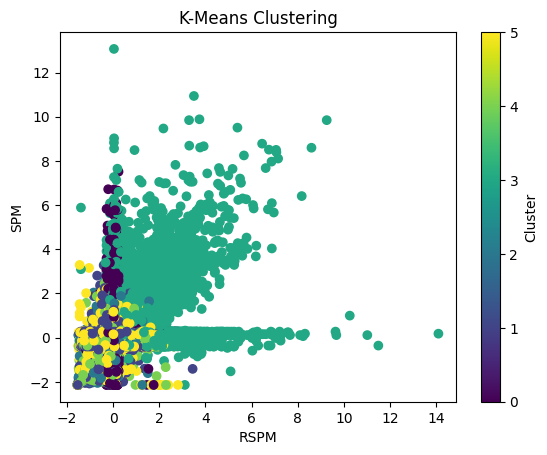

In [3]:
import matplotlib.pyplot as plt

# Visualize the clusters in 2D (using rspm and spm)
plt.scatter(df_sampled['rspm_scaled'], df_sampled['spm_scaled'], c=df_sampled['cluster'], cmap='viridis')
plt.xlabel('RSPM')
plt.ylabel('SPM')
plt.title('K-Means Clustering')
plt.colorbar(label='Cluster')
plt.show()


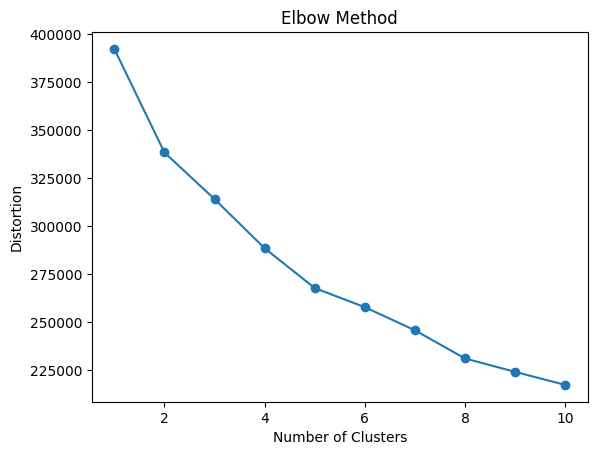

In [4]:
#To determine if the number of clusters (k) is optimal, you can evaluate the clustering using metrics like Silhouette Score or Elbow Method.

#Silhouette Score:

from sklearn.metrics import silhouette_score


# Step 5.1: Calculate distortions for different k values
distortions = []
for i in range(1, 11):  # Try for k = 1 to 10
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_sampled[['state_scaled', 'type_scaled', 'month_scaled', 'day_scaled', 'year_scaled', 'so2_scaled', 'no2_scaled', 'rspm_scaled', 'spm_scaled']])
    distortions.append(kmeans.inertia_)

# Step 5.2: Plot the elbow curve
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()



In [5]:
#Anomaly Detection
"""
Identify Distances to Centroids
After clustering, calculate the distance of each point to its cluster centroid. Points with the largest distances can be considered anomalies.
"""
import numpy as np

# Compute distances to the cluster centroid
df_sampled['Centroid_Distance'] = np.linalg.norm(
    df_sampled[['state_scaled', 'type_scaled', 'month_scaled', 'day_scaled', 'year_scaled', 'so2_scaled', 'no2_scaled', 'rspm_scaled', 'spm_scaled']] - kmeans.cluster_centers_[df_sampled['cluster']], axis=1
)



In [6]:
"""
Set a Threshold for Anomalies
Define a threshold distance above which points are considered anomalies. This can be based on:

Percentile: the top 5% of points with the largest distances.
"""
threshold = np.percentile(df_sampled['Centroid_Distance'], 95)  # Top 5% as anomalies
df_sampled['Anomaly'] = df_sampled['Centroid_Distance'] > threshold


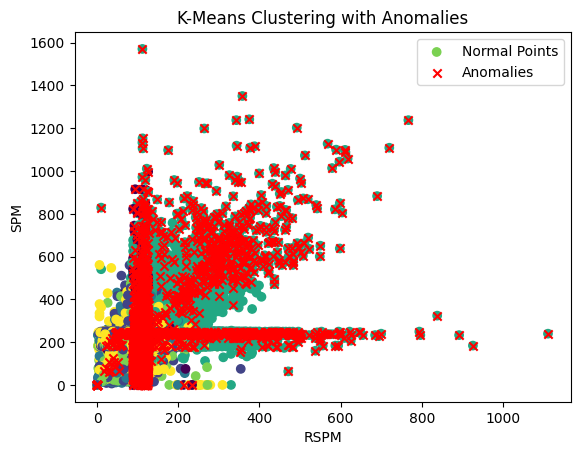

Silhouette Score: 0.09769941508283808
States with maximum anomalies:
state
West Bengal             307
Maharashtra             281
Uttar Pradesh           259
Rajasthan               204
Delhi                   181
Kerala                  158
Tamil Nadu              121
Gujarat                 119
Madhya Pradesh          101
Himachal Pradesh         91
Andhra Pradesh           69
Odisha                   48
Karnataka                36
Bihar                    35
Punjab                   31
Chandigarh               28
Daman & Diu              20
Assam                    17
Meghalaya                17
Goa                      15
Puducherry               13
Jharkhand                10
Haryana                   6
Chhattisgarh              6
Dadra & Nagar Haveli      5
Uttaranchal               1
Name: count, dtype: int64


In [7]:
"""
Analyze Anomalies
Visualize the anomalies in the context of the clusters.
"""
import matplotlib.pyplot as plt

plt.scatter(df_sampled['rspm'], df_sampled['spm'], c=df_sampled['cluster'], cmap='viridis', label='Normal Points')
plt.scatter(df_sampled[df_sampled['Anomaly']]['rspm'], df_sampled[df_sampled['Anomaly']]['spm'], 
            color='red', label='Anomalies', marker='x')
plt.xlabel('RSPM')
plt.ylabel('SPM')
plt.title('K-Means Clustering with Anomalies')
plt.legend()
plt.show()

# Save anomalies to a CSV file
anomalies = df_sampled[df_sampled['Anomaly']]  # Filter anomalies
anomalies.to_csv("anomalies.csv", index=False)  # Save to CSV file

from sklearn.metrics import silhouette_score

score = silhouette_score(df_sampled[['state_scaled', 'type_scaled', 'month_scaled', 'day_scaled', 'year_scaled', 'so2_scaled', 'no2_scaled', 'rspm_scaled', 'spm_scaled']], df_sampled['cluster'])
print(f"Silhouette Score: {score}")

# -1 logic appears only for DBSCAN

#printing the states with maximum to minimum anomalies
def get_states_with_max_anomalies(file_path):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Check if 'state' column exists
    if 'state' not in df.columns:
        raise ValueError("The 'state' column is missing from the CSV.")
    
    # Count anomalies for each state
    state_anomaly_count = df['state'].value_counts()  # counts occurrences of each state
    
    # Sort the states based on the count of anomalies in descending order
    sorted_states = state_anomaly_count.sort_values(ascending=False)
    
    return sorted_states

# Usage
file_path = 'anomalies.csv'  # Path to your anomalies CSV file
states_order = get_states_with_max_anomalies(file_path)

# Print the ordered states
print("States with maximum anomalies:")
print(states_order)

#Anomaly means outliers in the cluster most of the times

In [8]:
"""
Using DBSCAN for Density-Based Anomaly Detection
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is effective for detecting points in low-density regions.

"""

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.2, min_samples=5)
df_sampled['DBSCAN_Labels'] = dbscan.fit_predict(df_sampled[['state_scaled', 'type_scaled', 'month_scaled', 'day_scaled', 'year_scaled','rspm', 'so2', 'no2', 'spm']])


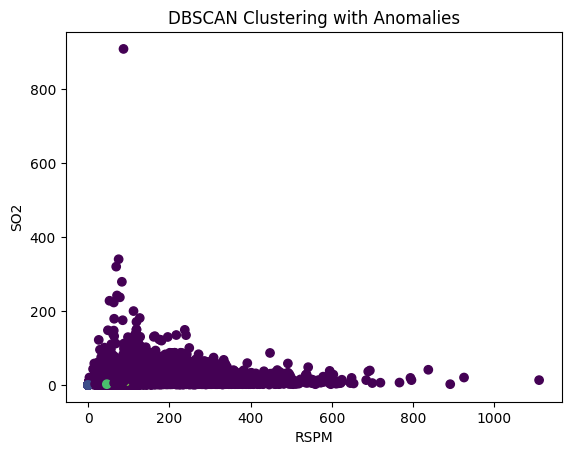

'\nAnomalies/Noise\nPoints labeled as -1 (anomalies or noise) are shown in a distinct color (often black or gray in the viridis colormap).\nThese points are in low-density regions and do not belong to any cluster. They might represent:\nOutliers in the dataset.\nRare events or unusual data patterns.\n'

In [9]:
import matplotlib.pyplot as plt

plt.scatter(df_sampled['rspm'], df_sampled['so2'], c=df_sampled['DBSCAN_Labels'], cmap='viridis')
plt.xlabel('RSPM')
plt.ylabel('SO2')
plt.title('DBSCAN Clustering with Anomalies')
plt.show()

"""
Anomalies/Noise
Points labeled as -1 (anomalies or noise) are shown in a distinct color (often black or gray in the viridis colormap).
These points are in low-density regions and do not belong to any cluster. They might represent:
Outliers in the dataset.
Rare events or unusual data patterns.
"""


In [10]:
from sklearn.metrics import silhouette_score

score = silhouette_score(df_sampled[['state_scaled', 'type_scaled', 'month_scaled', 'day_scaled', 'year_scaled', 'rspm', 'so2', 'no2', 'spm']], df_sampled['DBSCAN_Labels'])
print(f"Silhouette Score: {score}")

"""
#Silhouette Score Range:
+1: Perfect separation of clusters. Points are far from neighboring clusters and close to their own cluster center.
0: Points are on or very close to the boundary between clusters, indicating overlapping or poorly separated clusters.
-1: Points are assigned to the wrong cluster.
Interpretation of 0.646:
A score of 0.646 indicates reasonably well-separated clusters.
Points are generally closer to their own cluster center than to the centers of neighboring clusters.
The clustering seems to capture the structure in the data effectively.
"""

Silhouette Score: -0.615297377719008


'\n#Silhouette Score Range:\n+1: Perfect separation of clusters. Points are far from neighboring clusters and close to their own cluster center.\n0: Points are on or very close to the boundary between clusters, indicating overlapping or poorly separated clusters.\n-1: Points are assigned to the wrong cluster.\nInterpretation of 0.646:\nA score of 0.646 indicates reasonably well-separated clusters.\nPoints are generally closer to their own cluster center than to the centers of neighboring clusters.\nThe clustering seems to capture the structure in the data effectively.\n'

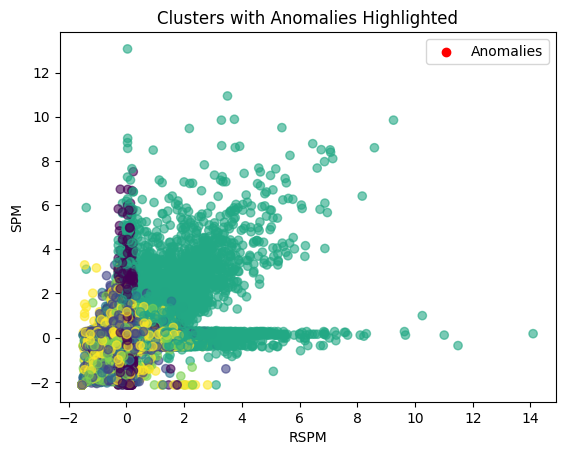

Anomalies summary:
               so2         no2         rspm          spm          day  \
count  2179.000000  2179.00000  2179.000000  2179.000000  2179.000000   
mean     17.307628    44.78589   187.204318   313.505146     8.372189   
std      32.466749    46.84029   134.527426   242.276784    10.102349   
min       0.000000     0.00000     0.000000     0.000000     1.000000   
25%       6.000000    13.15000   108.759003   146.000000     1.000000   
50%       9.900000    26.80000   118.903383   236.505825     1.000000   
75%      15.500000    63.20000   254.166667   450.500000    17.000000   
max     909.000000   696.00000  1111.000000  1571.000000    31.000000   

              year  state_encoded  location_encoded  type_encoded  \
count  2179.000000    2179.000000       2179.000000   2179.000000   
mean   2000.940340      19.657182        122.837081      4.102799   
std       8.476301       9.284576         78.177758      2.498206   
min    1987.000000       0.000000          1.00

In [11]:
# Visualize anomalies
import matplotlib.pyplot as plt

plt.scatter(df_sampled['rspm_scaled'], df_sampled['spm_scaled'], c=df_sampled['cluster'], cmap='viridis', alpha=0.6)
plt.scatter(df_sampled[df_sampled['cluster'] == -1]['rspm'],
            df_sampled[df_sampled['cluster'] == -1]['spm'], color='red', label='Anomalies')
plt.xlabel('RSPM')
plt.ylabel('SPM')
plt.legend()
plt.title('Clusters with Anomalies Highlighted')
plt.show()

# Investigate anomalies
anomalies1 = df_sampled[df_sampled['cluster'] == -1]
print("Anomalies summary:")
print(anomalies.describe())

# Save anomalies for further analysis
anomalies1.to_csv("anomalies1.csv", index=False)
